# ♛ Giải Thuật Di Truyền (Genetic Algorithm) - Bài Toán N Quân Hậu

---

## Giới thiệu bài toán

Bài toán **N quân hậu**: đặt N quân hậu trên bàn cờ N×N sao cho không quân nào tấn công nhau.

## Giải thuật di truyền (GA)

GA là một phương pháp tối ưu hoá lấy cảm hứng từ tiến hoá sinh học:

1. **Quần thể (Population)**: tập hợp các lời giải.
2. **Fitness**: đo độ phù hợp của lời giải.
3. **Chọn lọc (Selection)**: chọn lời giải tốt để sinh ra thế hệ mới.
4. **Lai ghép (Crossover)**: kết hợp hai lời giải để tạo lời giải mới.
5. **Đột biến (Mutation)**: thay đổi ngẫu nhiên để tạo đa dạng.
6. Lặp lại cho đến khi tìm được lời giải tối ưu hoặc đạt số thế hệ giới hạn.


## Cấu hình thuật toán

Xác định các tham số chính của GA:

- `N`: số quân hậu.
- `POP_SIZE`: kích thước quần thể.
- `MUTATION_RATE`: xác suất đột biến.
- `MAX_GEN`: số thế hệ tối đa.


In [22]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, animation
from IPython.display import HTML

N = 8
POP_SIZE = 500
MUTATION_RATE = 0.6
MAX_GEN = 350

## Hàm GA cơ bản - Khởi tạo cá thể

Mỗi cá thể là một mảng độ dài N, giá trị tại vị trí `i` là hàng của quân hậu trong cột `i`.

- Ví dụ: `[0, 4, 7, 5, 2, 6, 1, 3]` nghĩa là quân hậu ở cột 0 hàng 0, cột 1 hàng 4,...


In [23]:
def create_individual():
    return [random.randint(0, N - 1) for _ in range(N)]

## Hàm GA cơ bản - Tính fitness

**Fitness** là tỉ lệ số cặp quân hậu **không tấn công nhau** trên tổng số cặp có thể có.

- Tổng số cặp = `N*(N-1)/2`.
- Hai quân hậu tấn công nhau nếu cùng hàng hoặc cùng đường chéo.


In [24]:
def fitness(ind):
    total_pairs = N * (N - 1) // 2
    non_attacking = 0
    for i in range(N):
        for j in range(i + 1, N):
            if ind[i] != ind[j] and abs(ind[i] - ind[j]) != abs(i - j):
                non_attacking += 1
    return non_attacking / total_pairs

## Hàm GA cơ bản - Chọn lọc (Selection)

Sử dụng **tournament selection**: chọn ngẫu nhiên 3 cá thể, lấy cá thể tốt nhất (fitness cao nhất) làm cha/mẹ.


In [25]:
def selection(pop):
    tour = random.sample(pop, 3)
    tour.sort(key=lambda x: fitness(x), reverse=True)
    return tour[0]

## Hàm GA cơ bản - Lai ghép (Crossover)

Cắt một điểm trên chuỗi gene và ghép từ hai cha mẹ để tạo con mới.


In [26]:
def crossover(p1, p2):
    point = random.randint(1, N - 2)
    return p1[:point] + p2[point:]

## Hàm GA cơ bản - Đột biến (Mutation)

Với xác suất `MUTATION_RATE`, chọn ngẫu nhiên một cột và thay đổi hàng của quân hậu thành giá trị mới.


In [27]:
def mutate(ind):
    if random.random() < MUTATION_RATE:
        col = random.randint(0, N - 1)
        ind[col] = random.randint(0, N - 1)
    return ind

## Hàm vẽ bàn cờ

Vẽ bàn cờ màu gỗ thật với quân hậu ♛ đặt ở vị trí tương ứng.


In [28]:
def draw_board(ax, solution):
    light_color = "#f0d9b5"
    dark_color = "#b58863"
    board = np.zeros((N, N))
    board[1::2, ::2] = 1
    board[::2, 1::2] = 1
    cmap = colors.ListedColormap([light_color, dark_color])
    ax.imshow(board, cmap=cmap)

    for col, row in enumerate(solution):
        # Đường ngang
        ax.plot([0, N - 1], [row, row], color="orange", alpha=0.3)
        # Đường dọc
        ax.plot([col, col], [0, N - 1], color="orange", alpha=0.3)
        # Đường chéo chính (↘↖)
        for step in range(1, N):
            if 0 <= row + step < N and 0 <= col + step < N:
                ax.plot([col, col + step], [row, row + step], color="red", alpha=0.3)
            if 0 <= row - step < N and 0 <= col - step < N:
                ax.plot([col, col - step], [row, row - step], color="red", alpha=0.3)
        # Đường chéo phụ (↗↙)
        for step in range(1, N):
            if 0 <= row - step < N and 0 <= col + step < N:
                ax.plot([col, col + step], [row, row - step], color="blue", alpha=0.3)
            if 0 <= row + step < N and 0 <= col - step < N:
                ax.plot([col, col - step], [row, row + step], color="blue", alpha=0.3)

    for col, row in enumerate(solution):
        ax.text(
            col,
            row,
            "\u265b",
            ha="center",
            va="center",
            fontsize=48,
            color="black",
            fontweight="bold",
        )
    ax.set_xticks([])
    ax.set_yticks([])

## Chạy GA & lưu lịch sử

Lưu lại:

- `history`: cấu hình quân hậu tốt nhất ở mỗi thế hệ.
- `best_fitness_per_gen`: fitness cao nhất ở mỗi thế hệ.


In [29]:
population = [create_individual() for _ in range(POP_SIZE)]
history = []
best_fitness_per_gen = []

for gen in range(MAX_GEN):
    population.sort(key=lambda x: fitness(x), reverse=True)
    best = population[0]
    best_f = fitness(best)
    best_fitness_per_gen.append(best_f)
    history.append(best.copy())
    if best_f == 1.0:
        print(f"✨ Tìm được lời giải ở thế hệ {gen}!")
        break
    new_pop = []
    for _ in range(POP_SIZE):
        p1 = selection(population)
        p2 = selection(population)
        child = crossover(p1, p2)
        child = mutate(child)
        new_pop.append(child)
    population = new_pop

✨ Tìm được lời giải ở thế hệ 5!


## Biểu đồ tiến hóa Fitness

Biểu đồ có:

- Vùng nền bóng mờ thể hiện xu hướng.
- Marker và chú thích điểm fitness cao nhất.


In [30]:
gens = np.arange(len(best_fitness_per_gen))
vals = np.array(best_fitness_per_gen)
max_gen = np.argmax(vals)
import plotly.graph_objs as go
import plotly.io as pio

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=gens,
        y=vals,
        mode="lines+markers",
        line=dict(color="#007acc", width=3),
        marker=dict(size=8),
        name="Fitness tốt nhất",
    )
)

fig.add_trace(
    go.Scatter(
        x=[max_gen],
        y=[vals[max_gen]],
        mode="markers+text",
        marker=dict(color="red", size=16, line=dict(color="black", width=2)),
        text=[f"Max: {vals[max_gen]:.3f}"],
        textposition="top center",
        name="Fitness cao nhất",
    )
)

fig.update_layout(
    title="📈 Tiến hóa Fitness qua các thế hệ (GA N-Queens)",
    xaxis_title="Thế hệ",
    yaxis_title="Fitness tốt nhất",
    yaxis=dict(range=[0.8, 1.02]),
    legend=dict(x=0.01, y=0.99),
    plot_bgcolor="#f9f9f9",
    width=800,
    height=400,
)

fig.show()

## Animation mô phỏng quá trình đặt quân hậu

Hiển thị bàn cờ theo từng thế hệ, cho thấy sự tiến hóa của lời giải.


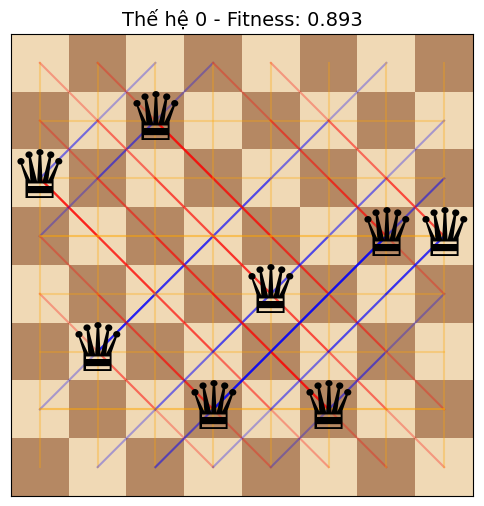

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))


def update(frame):
    ax.clear()
    draw_board(ax, history[frame])
    ax.set_title(
        f"Thế hệ {frame} - Fitness: {best_fitness_per_gen[frame]:.3f}", fontsize=14
    )


anim = animation.FuncAnimation(
    fig, update, frames=len(history), interval=500, repeat=False
)
HTML(anim.to_jshtml())

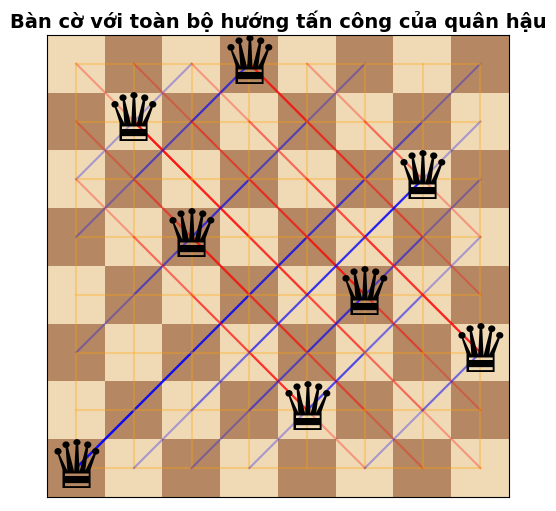

In [32]:
# Vẽ bàn cờ với tất cả các hướng tấn công của quân hậu
def draw_board_with_attacks(solution):
    fig, ax = plt.subplots(figsize=(6, 6))
    light_color = "#f0d9b5"
    dark_color = "#b58863"
    board = np.zeros((N, N))
    board[1::2, ::2] = 1
    board[::2, 1::2] = 1
    cmap = colors.ListedColormap([light_color, dark_color])
    ax.imshow(board, cmap=cmap)

    for col, row in enumerate(solution):
        # ----- Đường ngang -----
        ax.plot([0, N - 1], [row, row], color="orange", alpha=0.3)

        # ----- Đường dọc -----
        ax.plot([col, col], [0, N - 1], color="orange", alpha=0.3)

        # ----- Đường chéo chính (↘↖) -----
        for step in range(1, N):
            if 0 <= row + step < N and 0 <= col + step < N:
                ax.plot([col, col + step], [row, row + step], color="red", alpha=0.3)
            if 0 <= row - step < N and 0 <= col - step < N:
                ax.plot([col, col - step], [row, row - step], color="red", alpha=0.3)

        # ----- Đường chéo phụ (↗↙) -----
        for step in range(1, N):
            if 0 <= row - step < N and 0 <= col + step < N:
                ax.plot([col, col + step], [row, row - step], color="blue", alpha=0.3)
            if 0 <= row + step < N and 0 <= col - step < N:
                ax.plot([col, col - step], [row, row + step], color="blue", alpha=0.3)

    # Vẽ quân hậu
    for col, row in enumerate(solution):
        ax.text(
            col,
            row,
            "\u265b",
            ha="center",
            va="center",
            fontsize=48,
            color="black",
            fontweight="bold",
        )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(
        "Bàn cờ với toàn bộ hướng tấn công của quân hậu", fontsize=14, fontweight="bold"
    )
    plt.show()


# Gọi hàm với lời giải cuối
draw_board_with_attacks(history[-1])